In [13]:
# Some common data manipulation imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

#some other imports
import os
pd.set_option('display.max_rows', 100000)

# For stable output on each run
np.random.seed(3)

# To plot easily visible pictures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
original = pd.read_csv('500_nodes.csv')
original = original.drop(['date', 'name'], axis=1)
train, test = train_test_split(original, test_size=0.2)
train_original = train.copy()
test_original = test.copy()

In [3]:
print(train.info(verbose = 1))
print(test.info(verbose = 1))
print(train.describe())
print(test.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438000 entries, 108634 to 71530
Data columns (total 153 columns):
 #   Column                   Dtype
---  ------                   -----
 0   manufacture_discontinue  int64
 1   power_supply_rf          int64
 2   cpu_rf                   int64
 3   memory_rf                int64
 4   location_rf              int64
 5   mis_config_rf            int64
 6   os_upgrade_rf            int64
 7   avg_link_rf              int64
 8   card0_rf                 int64
 9   card1_rf                 int64
 10  card2_rf                 int64
 11  card3_rf                 int64
 12  card4_rf                 int64
 13  card5_rf                 int64
 14  card6_rf                 int64
 15  card7_rf                 int64
 16  card8_rf                 int64
 17  card9_rf                 int64
 18  card10_rf                int64
 19  card11_rf                int64
 20  card12_rf                int64
 21  card13_rf                int64
 22  card14_rf      

       manufacture_discontinue  power_supply_rf         cpu_rf      memory_rf  \
count            438000.000000    438000.000000  438000.000000  438000.000000   
mean                 44.812900         4.989575       7.150144       6.232395   
std                  15.820763         2.981228       0.569433       0.589335   
min                   0.000000         0.000000       6.000000       5.000000   
25%                  33.000000         2.000000       7.000000       6.000000   
50%                  49.000000         5.000000       7.000000       6.000000   
75%                  60.000000         8.000000       7.000000       7.000000   
max                  60.000000        10.000000       9.000000       8.000000   

         location_rf  mis_config_rf  os_upgrade_rf    avg_link_rf  \
count  438000.000000  438000.000000  438000.000000  438000.000000   
mean        4.970674       5.011660       4.933600       5.569671   
std         3.128858       3.201725       3.136144       1.1999

In [4]:
from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import time
from keras.callbacks import TensorBoard
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import csv
from keras.utils.vis_utils import plot_model
from keras.callbacks import History
from matplotlib import pyplot as plt
#normalizing the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas import DataFrame
from sklearn.metrics import classification_report, confusion_matrix
import time

Using TensorFlow backend.


In [5]:
# pip install memory_profiler

In [6]:
from memory_profiler import memory_usage

# Define custom callback to save memory usage at end of each epoch
class MemoryUsageCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mem_usage = memory_usage(-1, interval=1, timeout=1)
        self.model.mem_usage.append(np.mean(mem_usage))

In [7]:
def normalize(train, test):
    train_max = train.loc[:, train.columns != 'target']
    test_max = test.loc[:, test.columns != 'target']
    Y_train = train.loc[:, train.columns == 'target']
    Y_test = test.loc[:, test.columns == 'target']
    scaler = StandardScaler()
    train_p = scaler.fit_transform(train_max)#.loc[:, train.columns!='Class'])
    train_p = DataFrame(train_p)
    train_p.columns = train_max.columns.values
    test_p = scaler.fit_transform(test_max)#.loc[:, test.columns!='Class'])
    test_p = DataFrame(test_p)
    test_p.columns = test_max.columns.values
    
    return train_p, Y_train, test_p, Y_test

In [8]:
train_s, Y_train, test_s, Y_test = normalize(train, test)
len(test_s.columns)

152

In [9]:
model = Sequential()

model.add(Dense(128, input_shape=(152,), activation='relu'))

model.add(Dense(256,activation="relu",use_bias=True))
model.add(Dropout(0.1))

# 2) without this layer--------
model.add(Dense(256,activation="relu",use_bias=True))
model.add(Dropout(0.25))
#------------------------------
model.add(Dense(512,activation="relu",use_bias=True))
model.add(Dropout(0.5))

# 1). without these layers-------------
# model.add(Dense(512,activation="relu",use_bias=True))
# model.add(Dropout(0.5))

# model.add(Dense(1024,activation="relu",use_bias=True))
# model.add(Dropout(0.5))
# ------------------------------------
model.add(Dense(1024,activation="relu",use_bias=True))
model.add(Dropout(0.5))

model.add(Dense(512,activation="relu",use_bias=True))
model.add(Dropout(0.25))

model.add(Dense(256,activation="relu",use_bias=True))
model.add(Dropout(0.1))

model.add(Dense(128,activation="relu",use_bias=True))

model.add(Dense(units=10,activation="softmax"))

opt= Adam(lr=.0001)
model.compile(optimizer=opt, loss = "sparse_categorical_crossentropy", metrics= ["accuracy"])

# Initialize memory usage list in model object
model.mem_usage = []

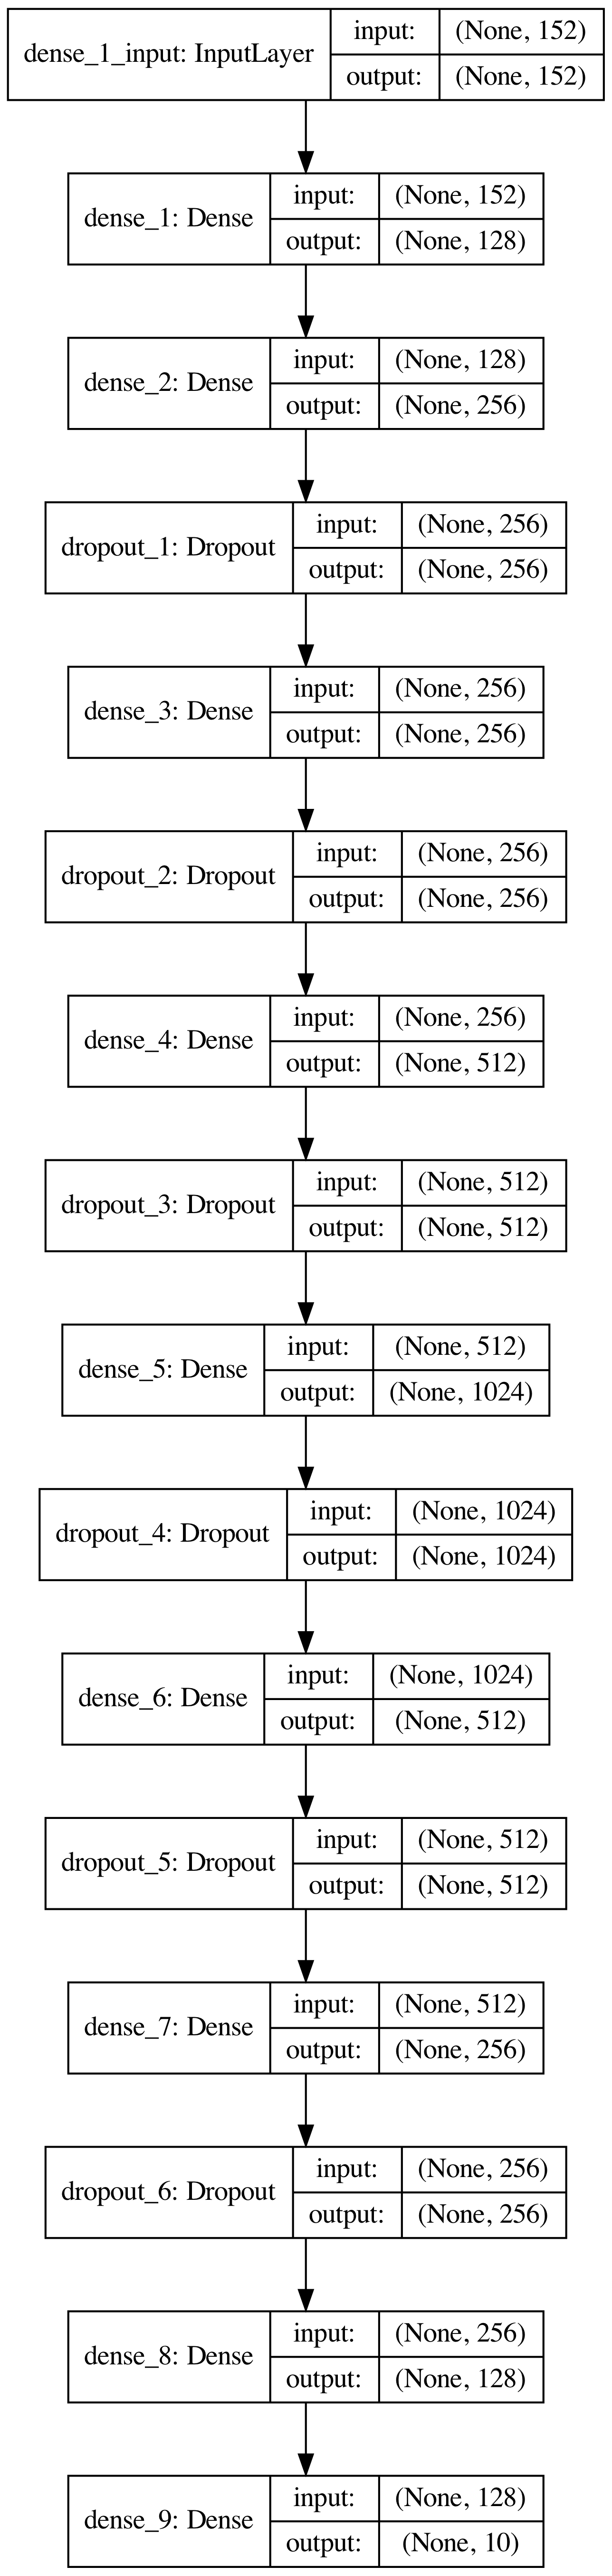

In [27]:
from keras.utils.vis_utils import plot_model

plot_model(model, 
           to_file='DNN.png', rankdir='TB', show_shapes=True, show_layer_names=True, expand_nested=True, 
           dpi=300)

In [10]:
test['target'].value_counts()

0    24053
7    23435
9    22113
8    16261
6    12523
3     6504
5     1742
1     1719
2      585
4      565
Name: target, dtype: int64

In [11]:
# Train model and time it
start_time = time.time()

history = model.fit(
    train_s,
    Y_train,
    batch_size=128,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_split= 0.2,
    callbacks=[MemoryUsageCallback()]
)
end_time = time.time()
# Calculate time taken to train
time_taken = end_time - start_time

Train on 350400 samples, validate on 87600 samples
Epoch 1/20
350400/350400 [==============================] - 188s 536us/step - loss: 0.5059 - accuracy: 0.8205 - val_loss: 0.1169 - val_accuracy: 0.9611
Epoch 2/20
350400/350400 [==============================] - 210s 599us/step - loss: 0.1269 - accuracy: 0.9586 - val_loss: 0.0958 - val_accuracy: 0.9660
Epoch 3/20
350400/350400 [==============================] - 205s 585us/step - loss: 0.1039 - accuracy: 0.9639 - val_loss: 0.0914 - val_accuracy: 0.9671
Epoch 4/20
350400/350400 [==============================] - 214s 612us/step - loss: 0.0937 - accuracy: 0.9666 - val_loss: 0.0848 - val_accuracy: 0.9699
Epoch 5/20
350400/350400 [==============================] - 205s 586us/step - loss: 0.0863 - accuracy: 0.9686 - val_loss: 0.0793 - val_accuracy: 0.9711
Epoch 6/20
350400/350400 [==============================] - 203s 580us/step - loss: 0.0802 - accuracy: 0.9711 - val_loss: 0.0788 - val_accuracy: 0.9729
Epoch 7/20
350400/350400 [===========

In [12]:
print("Time taken to train the model: ", time_taken, "seconds")
# Print memory usage
print("Memory usage per epoch: {}".format(model.mem_usage))

Time taken to train the model:  4734.670771121979 seconds
Memory usage per epoch: [2590.4375, 1738.65625, 2589.734375, 602.734375, 2594.234375, 947.625, 2428.84375, 2518.265625, 2589.21875, 2587.484375, 1837.03125, 2585.265625, 2586.5, 2542.21875, 2392.890625, 1676.328125, 2493.875, 1938.71875, 1670.84375, 2575.5625]


In [13]:
t_pred = model.predict(test_s)
pred = np.argmax(t_pred, axis=1)
print('Classification Report')
target_names = ['0','1','2','3','4','5', '6', '7', '8', '9']
f1 = classification_report(Y_test, pred, target_names=target_names)
print(f1)

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24053
           1       0.98      0.97      0.98      1719
           2       1.00      0.99      1.00       585
           3       0.91      0.81      0.86      6504
           4       0.92      1.00      0.96       565
           5       0.98      1.00      0.99      1742
           6       0.98      0.99      0.98     12523
           7       0.99      0.99      0.99     23435
           8       0.99      0.99      0.99     16261
           9       0.98      1.00      0.99     22113

    accuracy                           0.98    109500
   macro avg       0.97      0.97      0.97    109500
weighted avg       0.98      0.98      0.98    109500



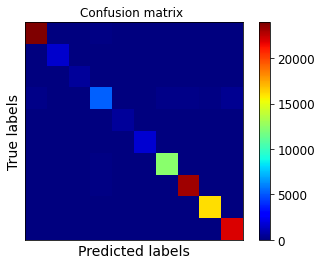

In [14]:
true = Y_test.T.to_numpy()
true = true.reshape(true.shape[1:])

conf = confusion_matrix(true, pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])#'2','3','4','5', '6', '7', '8', '9'])
plt.imshow(conf, cmap=plt.cm.jet)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
#print(mode

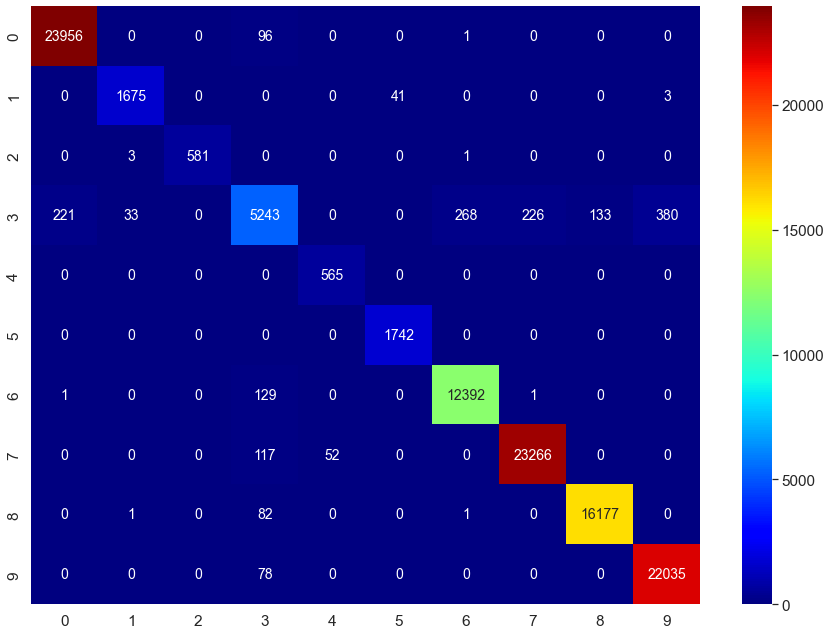

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import calendar
import time

current_GMT = time.gmtime()

time_stamp = calendar.timegm(current_GMT)

df_cm = pd.DataFrame(conf, range(10), range(10))
plt.figure(figsize=(15, 11))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, cmap=plt.cm.jet, fmt="d") # font size

filename = "large_conf_" + str(time_stamp) + '.png' 
plt.savefig(filename , dpi=300, bbox_inches='tight')

plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


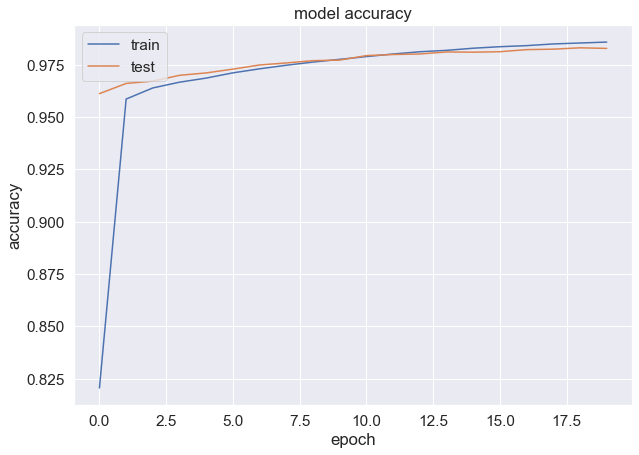

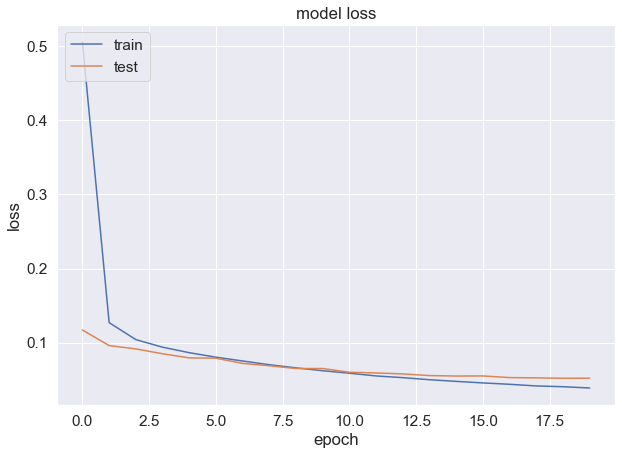

In [16]:
print(history.history.keys())
# summarize history for accuracy
filename = "large_acc_" + str(time_stamp) + '.png' 
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(filename , dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10, 7))
# summarize history for loss
filename = "large_loss_" + str(time_stamp) + '.png' 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(filename , dpi=300, bbox_inches='tight')
plt.show()